<a href="https://colab.research.google.com/github/Amrin36/Amrin36.github.io/blob/main/mobilenet_grocery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# General Libs
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
im_shape = (224,224)
TRAINING_DIR = '/content/drive/MyDrive/ML_Sessional/GroceryStoreDataset-master/dataset/train'
VAL_DIR = '/content/drive/MyDrive/ML_Sessional/GroceryStoreDataset-master/dataset/val'
TEST_DIR = '/content/drive/MyDrive/ML_Sessional/GroceryStoreDataset-master/dataset/test'

seed = random.randint(1, 1000)

BATCH_SIZE = 32
num_classes = 3

learning_rate = 0.0001

In [ ]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input) #rescale=1./255,

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")#, color_mode='grayscale')

val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = val_generator.flow_from_directory(VAL_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)#, color_mode='grayscale')
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)#rescale=1./255

test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=(im_shape[0],im_shape[1]), shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")#, color_mode='grayscale')
nb_test_samples = test_generator.samples

Found 2485 images belonging to 3 classes.


/content/drive/MyDrive/ML_Sessional/GroceryStoreDataset-master/dataset/train/Fruit/Lime/Lime_004.jpg
/content/drive/MyDrive/ML_Sessional/GroceryStoreDataset-master/dataset/test/Vegetables/Tomato/Vine-Tomato/Vine-Tomato_006.jpg


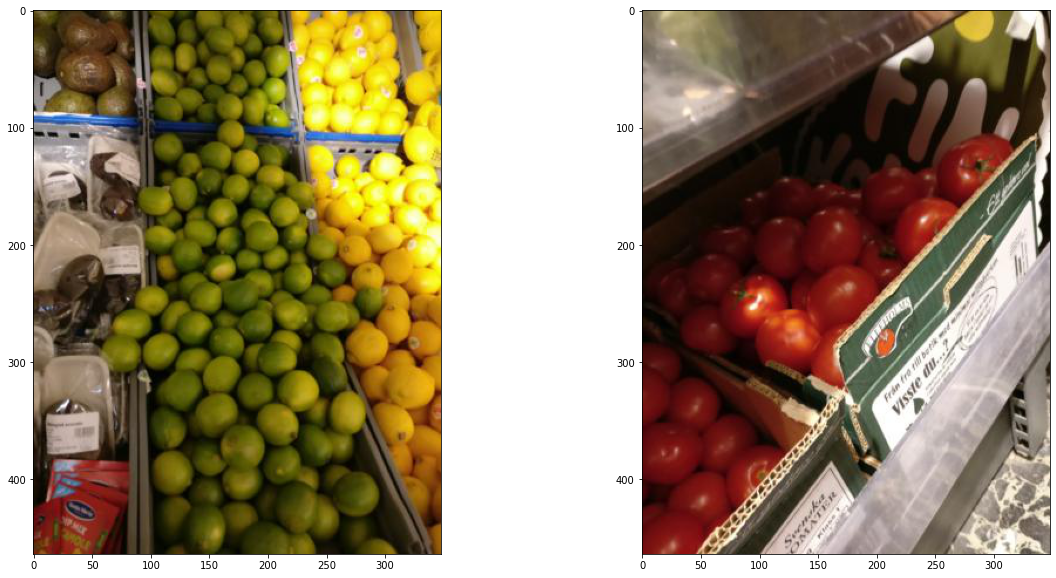

In [ ]:
# Looking for some examples

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
img = train_generator.filepaths[np.random.randint(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img);

plt.subplot(1, 2, 2)
img = test_generator.filepaths[np.random.randint(low=0, high=test_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img);

In [ ]:
# Loading MobileNet without top layer
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate = .4)(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed))(x)
x = Dropout(rate = .4)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing MobileNet layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam(lr=learning_rate)

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 0.7705779334500875, 1: 1.0185185185185186, 2: 1.38801261829653}

In [ ]:
epochs = 20

#Save the best model acoording to validation loss
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,verbose=1)
]

history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE,
        class_weight = class_weights)

Epoch 1/20
82/82 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9176 
Epoch 1: val_loss improved from inf to 0.09419, saving model to model.h5
82/82 [==============================] - 1035s 12s/step - loss: 0.2101 - accuracy: 0.9176 - val_loss: 0.0942 - val_accuracy: 0.9618
Epoch 2/20
82/82 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9732
Epoch 2: val_loss did not improve from 0.09419
82/82 [==============================] - 13s 153ms/step - loss: 0.0797 - accuracy: 0.9732 - val_loss: 0.1012 - val_accuracy: 0.9722
Epoch 3/20
82/82 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9801
Epoch 3: val_loss did not improve from 0.09419
82/82 [==============================] - 12s 152ms/step - loss: 0.0562 - accuracy: 0.9801 - val_loss: 0.1095 - val_accuracy: 0.9757
Epoch 4/20
82/82 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9755
Epoch 4: val_loss improved from 0.09419 to 0.09182, saving m

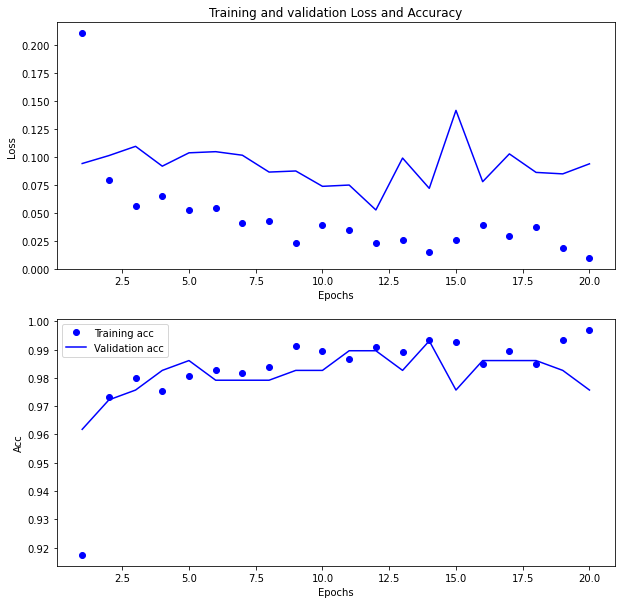

In [ ]:
# How the training was
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

In [ ]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, nb_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Fruit', 'Packages', 'Vegetables']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[1100    0   17]
 [   0  781    0]
 [  32    0  555]]
Classification Report
              precision    recall  f1-score   support

       Fruit       0.97      0.98      0.98      1117
    Packages       1.00      1.00      1.00       781
  Vegetables       0.97      0.95      0.96       587

    accuracy                           0.98      2485
   macro avg       0.98      0.98      0.98      2485
weighted avg       0.98      0.98      0.98      2485

